# Problem Set 3, Solution

**Stats 507, Fall 2021**

*Dingyu Wang*   

*October 4, 2021*

## Import
The remaining questions will use the following imports.

In [1]:
# modules: --------------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from os.path import exists
from scipy.stats import norm
from IPython.core.display import display, HTML
from matplotlib._pylab_helpers import Gcf
from IPython.core.pylabtools import print_figure 
from base64 import b64encode
# 79: -------------------------------------------------------------------------

## Question 0 - RECS and Replicate Weights
### Data Files
[2009 Variable and response codebook](
https://www.eia.gov/consumption/residential/data/2009/xls/recs2009_public_codebook.xlsx
)

[2009 Replicate weights files](
https://www.eia.gov/consumption/residential/data/2009/csv/recs2009_public_repweights.csv
)

[2009 Data files](https://www.eia.gov/consumption/residential/data/2009/csv/recs2009_public.csv
)

[2015 Variable and response codebook](https://www.eia.gov/consumption/residential/data/2015/xls/codebook_publicv4.xlsx
)

[2015 Data files](
https://www.eia.gov/consumption/residential/data/2015/csv/recs2015_public_v4.csv
)

### Variables
* DOEID(unique identifier for each respondent), 
* NWEIGHT(final sample weight), 
* BRRWT(replicate weight),
* REGIONC(census region), 
* HDD65(heating degree days, base temperature 65F), 
* CDD65(cooling degree days, base temperature 65F),
* HDD50(heating degree days, base temperature 50F),
* CDD80(cooling degree days, base temperature 80F).

### Weights and Replicate Weights
[2009 replicate weights instruction](
https://www.eia.gov/consumption/residential/methodology/2009/pdf/using-microdata-022613.pdf
)

[2015 replicate weights instruction](
https://www.eia.gov/consumption/residential/data/2015/pdf/microdata_v3.pdf
)

The data files contains a column called NWEIGHT, which from my prespective
can be regard as the number of households that the particular case
represents. Therefore, whenever we need to make a point estimatation, we need
to include NWEIGHT in our calculation. Replicate weights, which in the data
files are balanced repeated replicate (brr) weights, reweight each cases. So,
as for one estimator, we can have a lot of predicted values in terms of each
brr weights. When we have these predicted values and the point estimation, we
can calculate the standard error of the estimator by applying the following
equation. Finally, according to the confidence level, we can get the
confidence interval of the estimator.

$\theta$ is a population parameter of interest, let $\widehat{\theta}$ be the
estimate from the full sample for $\theta$. Let $\widehat{\theta_r}$ be the
estimate from the r-th replicate subsample by using replicate weights and
let $\epsilon$ be the Fay coefficient, $0\leq\epsilon <1$. The standard error
of $\widehat\theta$ is estimated by:

$$standard\ \ error(\widetilde{\theta}) = \sqrt{\frac{1}{R(1-\epsilon)^2}
\sum_{r=1}^{R}(\widehat{\theta_r}-\widehat{\theta})^2}$$

As for our data files, $\epsilon=0.5$.

## Question 1 - Data Preparation

Download the data from the website when local versions of the files are not
available and write local copies of the datasets, so the data are only
downloaded when not already available locally. Therefore, I keep the download
url of each file as a list and use the following function to achieve my goal.

In [2]:
web = "https://www.eia.gov/consumption/residential/data/"
url = [web + "2009/csv/recs2009_public.csv",
       web + "2009/csv/recs2009_public_repweights.csv",
       web + "2009/xls/recs2009_public_codebook.xlsx",
       web + "2015/csv/recs2015_public_v4.csv",
       web + "2015/xls/codebook_publicv4.xlsx"]

In [3]:
def download(url):
    '''
    Download the data. If the data is already exist in the local environment,
    the function will read the data locally. If the data doesn't exist in the
    local environment, the function will read the data directly from the link
    we provide and then save the data file into our local environment.

    Parameters
    ----------
    url : str
        The link to the file's download website.

    Returns
    -------
    A DataFrame.
    '''
    path = url[url.rindex( '/' ) + 1 : len(url)] 
    if path[-3:] == "csv":
        if (exists(path)):
            df = pd.read_csv(path)
        else:
            df = pd.read_csv(url)
            df.to_csv(path)
    if path[-4:] == "xlsx":
        if (exists(path)):
            df = pd.read_excel(path)
        else:
            df = pd.read_excel(url)
            df.to_excel(path)
    return df

Apply the `download()` function to each url in the list, I first check if
there exist the file in my local environment, if the file exist, then I use
pandas to read the file, if not, I read the file directly from the website
and then save the file to my loacl environment.

In [4]:
data_09 = download(url[0])
weight_09 = download(url[1])
codebook_09 = download(url[2])
data_15 = download(url[3])
codebook_15 = download(url[4])

F:\python\lib\site-packages\ipykernel_launcher.py:1: DtypeWarning: Columns (718,719) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


### Part a) 
Separately for 2009 and 2015, construct datasets containing just the minimal
necessary variables identified in the warmup, excluding the replicate
weights. Choose an appropriate format for each of the remaining columns,
particularly by creating categorical types where appropriate.

In this part, I deal with data from 2019 and 2015 separately. In terms of
each dataset, I choose the variables needed to calculate the average heating
degree days and average cooling degree days, the variables are listed at the
Question 0. Then I rename each column with literate variable names using all
lower case and convert each column to an appropriate type, specifically, the
type of column "REGIONC" is category. Finally, I rename the processed dataset
as "data_09_new" and "data_15_new".

In [5]:
data_09_new = data_09.loc[:,["DOEID", "NWEIGHT", "REGIONC", "HDD65", "CDD65"]]
data_09_new = data_09_new.rename(
    columns={'DOEID':'id', 'NWEIGHT':'w', 'REGIONC': 'census_region',
             'HDD65':'heating_degree_days', 'CDD65':'cooling_degree_day'}
)
data_09_new = data_09_new.convert_dtypes()
data_09_new['census_region'] = pd.Categorical(
    data_09_new['census_region'].replace(
        {1: 'northeast', 2: 'midwest', 3:'south', 4:'west'}))

In [6]:
data_15_new = data_15.loc[:,["DOEID", "NWEIGHT", "REGIONC", "HDD65", "CDD65"]]
data_15_new = data_15_new.rename(
    columns={'DOEID':'id', 'NWEIGHT':'w', 'REGIONC': 'census_region',
             'HDD65':'heating_degree_days', 'CDD65':'cooling_degree_day'})
data_15_new = data_15_new.convert_dtypes()
data_15_new['census_region'] = pd.Categorical(data_15_new['census_region']
    .replace({1: 'northeast', 2: 'midwest', 3:'south', 4:'west'}))

In [7]:
# output the processed Dateframe: ---------------------------------------------
data_09_new

,id,w,census_region,heating_degree_days,cooling_degree_day
0,1,2471.68,midwest,4742,1080
1,2,8599.17,west,2662,199
2,3,8969.92,northeast,6233,505
3,4,18003.64,midwest,6034,672
4,5,5999.61,northeast,5388,702
...,...,...,...,...,...
12078,12079,10219.8,midwest,7671,332
12079,12080,8689.07,south,2085,2844
12080,12081,4697.21,midwest,7935,472
12081,12082,13155.68,west,5834,770


In [8]:
# output the processed Dateframe: ---------------------------------------------
data_15_new

,id,w,census_region,heating_degree_days,cooling_degree_day
0,10001,12085.16227,west,2031,1768
1,10002,14410.19627,south,1915,2795
2,10003,23325.95385,south,2263,2235
3,10004,12165.33319,midwest,3754,1374
4,10005,16717.67092,northeast,5401,993
...,...,...,...,...,...
5681,15682,14190.77054,midwest,6470,632
5682,15683,13617.6871,south,2512,2055
5683,15684,20365.17745,midwest,5941,937
5684,15685,15110.19635,south,1438,3464


### Part b) 
Separatley for 2009 and 2015, construct datasets containing just the unique
case ids and the replicate weights (not the primary final weight) in a “long”
format with one weight and residence per row.

In this part I use Regular expressions to search for columns with format
"brr_weight_" or "BRRWT", then I construct datasets containing just the
unique case ids and the replicate weights. Melt method in pandas is applied
to convert the DataFrame into a “long” format with one weight and residence
per row. Finally, I save the processed dataset as "data_09_repl" and
"data_15_repl".

In [9]:
data_09_repl = weight_09.drop(columns=['NWEIGHT'])
data_09_repl = data_09_repl.rename(columns={'DOEID':'id'})
find_col = r'brr_weight_\d'
value_col = [m for m in data_09_repl.columns if re.search(find_col,m) != None]
data_09_repl_weight = data_09_repl.melt(
    id_vars=['id'], value_vars=value_col, value_name='w'
)

In [10]:
find_col = r'BRRWT\d'
col = ['DOEID']
col.extend([m for m in data_15.columns if re.search(find_col,m) != None])
data_15_repl = data_15.loc[:,col]
data_15_repl.columns=data_15_repl.columns.map(lambda x:x.lower())
data_15_repl = data_15_repl.rename(columns={'doeid':'id'})
find_col = r'brrwt\d'
value_col = [m for m in data_15_repl.columns if re.search(find_col,m) != None]
data_15_repl_weight = data_15_repl.melt(
    id_vars=['id'], value_vars=value_col, value_name='w'
)

In [11]:
# output the processed Dateframe: ---------------------------------------------
data_09_repl_weight

,id,variable,w
0,1,brr_weight_1,3628.305158
1,2,brr_weight_1,4408.308000
2,3,brr_weight_1,13664.732100
3,4,brr_weight_1,9456.435434
4,5,brr_weight_1,8659.554041
...,...,...,...
2948247,12079,brr_weight_244,15669.237850
2948248,12080,brr_weight_244,3976.693639
2948249,12081,brr_weight_244,2479.082636
2948250,12082,brr_weight_244,17663.466590


In [12]:
# output the processed Dateframe: ---------------------------------------------
data_15_repl_weight

,id,variable,w
0,10001,brrwt1,16555.311270
1,10002,brrwt1,21486.287200
2,10003,brrwt1,12297.436760
3,10004,brrwt1,18553.958900
4,10005,brrwt1,8075.744168
...,...,...,...
545851,15682,brrwt96,20183.445250
545852,15683,brrwt96,19681.916720
545853,15684,brrwt96,29148.112150
545854,15685,brrwt96,20695.042680


## Question 2 - Construct and report the estimates 
### Part a)
Estimate the average number of heating and cooling degree days for residences
in each Census region for both 2009 and 2015. You should construct both point
estimates (using the wegihts) and 95% confidece intervals (using standard
errors estiamted with the repliacte weights). Report your results in a nicely
formatted table.

For this question, you should use pandas DataFrame methods wherever possible.
Do not use a module specifically supporting survey weighting.

In this part, I use two functions to calculate the mean and confidence
interval of heating and cooling degree days. Details of the function are
presented in the docstring.

In [15]:
def calculate_mean_day(df):
    '''
    Calculate the average of heating and cooling degree days of each census
    region for 2009 and 2015.

    Parameters
    ----------
    df : DataFrame
        Input data contains all the variables we select.

    Returns
    -------
    A Dataframe contains the average of heating and cooling degree days of each
    census region.
    '''
    df["weight_heat"] = df["w"] * df["heating_degree_days"]
    df["weight_cool"] = df["w"] * df["cooling_degree_day"]
    df = (
        df
        .groupby("census_region")
        .sum()
        .reset_index()
    )
    df_result = df.drop(columns=["heating_degree_days", "cooling_degree_day"])
    df_result["avg_heat_degree_day"] =  df["weight_heat"]/df["w"]
    df_result["avg_cool_degree_day"] =  df["weight_cool"]/df["w"]
    df_result = df_result.drop(columns=["w","weight_heat", "weight_cool","id"])
    return df_result

In [16]:
data_09_day_mean = calculate_mean_day(data_09_new)

In [15]:
data_15_day_mean = calculate_mean_day(data_15_new)

In [16]:
# construct a table, include a caption: ---------------------------------------
cap = """
<b> Table 1. </b> <em>Average heating and cooling degree days in each Census 
region for 2009.</em>
"""
columns = ["Census region","Average heating degree days(base 65F)",
           "Average cooling degree days(base 65F)"]
data_09_day_table = data_09_day_mean.copy()
data_09_day_table.columns = columns
t1 = data_09_day_table.to_html(index=False)
t1 = t1.rsplit('\n')
t1.insert(1, cap)
tab1 = ''
for i, line in enumerate(t1):
    tab1 += line
    if i < (len(t1) - 1):
        tab1 += '\n'

In [17]:
display(HTML(tab1))

Census region,Average heating degree days(base 65F),Average cooling degree days(base 65F)
midwest,6325.33703,660.888382
northeast,5700.988131,680.715125
south,2696.667536,2207.728377
west,3259.641431,1328.642144


In [18]:
# construct a table, include a caption: ---------------------------------------
cap = """
<b> Table 2. </b> <em>Average heating and cooling degree days in each Census 
region for 2015.</em>
"""
columns = ["Census region","Average heating degree days(base 65F)",
           "Average cooling degree days(base 65F)"]
data_15_day_table = data_15_day_mean.copy()
data_15_day_table.columns = columns
t2 = data_15_day_table.to_html(index=False)
t2 = t2.rsplit('\n')
t2.insert(1, cap)
tab2 = ''
for i, line in enumerate(t2):
    tab2 += line
    if i < (len(t2) - 1):
        tab2 += '\n'

In [19]:
display(HTML(tab2))

Census region,Average heating degree days(base 65F),Average cooling degree days(base 65F)
midwest,5785.490456,956.074312
northeast,5695.673003,983.919861
south,2211.879901,2639.850988
west,2814.830692,1576.774204


In [17]:
def var(df,epsilon=0.5):
    '''
    Calculate the variance of the estimate.

    Parameters
    ----------
    df : DataFrame
        A DataFrame contains all the variables we select.
    epsilon : int(optional)
        Parameters when calculate variance, and the default value is 0.5.

    Returns
    -------
    A DataFrame with variance of the estimates for eahc census region.
    '''
    a = pd.DataFrame(
        {"heat_var":((df['avg_heat_degree_day']-df['avg_heat_repl'])**2).
                        mean()/((1-epsilon)**2),
         "cool_var":((df['avg_cool_degree_day']-df['avg_cool_repl'])**2).
                        mean()/((1-epsilon)**2)
         }, index = [0]
    )
    return a

def calculate_interval(df_new, df_weight, df_mean, epsilon=0.5,level=0.975):
    '''
    Calculate the confidence interval of heating and cooling degree days of
    each census region for 2009 and 2015.

    Parameters
    ----------
    df_new : DataFrame
        Dataframe contains the origin data.
    df_weight: DataFrame
        Dataframe contains the replicate weights.
    df_mean : DataFrame
        Dataframe contains the average heating and cooling degree days.
    epsilon : int(optional)
        Parameters when calculate variance, and the default value is 0.5.
    level : int(optional)
        Confidence level, default value is 0.95.

    Returns
    -------
    A Dataframe contains the confidence interval of heating and cooling degree
    days of each census region.
    '''
    df_repl = pd.merge(df_new.drop(columns=['w', 'weight_heat','weight_cool']),
                       df_weight, on='id')
    df_repl['heat_weight'] = df_repl['heating_degree_days']*df_repl['w']
    df_repl['cool_weight'] = df_repl['cooling_degree_day']*df_repl['w']
    df_repl = (
        df_repl
        .groupby(['census_region','variable'])
        .sum()
        .reset_index()
        .drop(columns=['id','heating_degree_days','cooling_degree_day'])
    )
    df_repl['avg_heat_repl'] = df_repl['heat_weight']/df_repl['w']
    df_repl['avg_cool_repl'] = df_repl['cool_weight']/df_repl['w']

    df_var = pd.merge(df_mean,
                      df_repl.drop(columns=['w', 'heat_weight','cool_weight']),
                      on='census_region'
                      )
    print(df_var)
    df_var = (
        df_var
        .groupby('census_region')
        .apply(var)
        .reset_index()
        .drop(columns=['level_1'])
    )
    alpha = norm.ppf(level,0,1)
    df_day = pd.merge(df_mean, df_var, on = 'census_region')
    df_day["heat_lwr"] = (df_day['avg_heat_degree_day']
                          - alpha * (df_day['heat_var'])**0.5)
    df_day["heat_upr"] = (df_day['avg_heat_degree_day']
                          + alpha * (df_day['heat_var'])**0.5)
    df_day["cool_lwr"] = (df_day['avg_cool_degree_day']
                          - alpha * (df_day['cool_var'])**0.5)
    df_day["cool_upr"] = (df_day['avg_cool_degree_day']
                          + alpha * (df_day['cool_var'])**0.5)
    return df_day

In [18]:
data_09_day_interval = calculate_interval(data_09_new,
                                          data_09_repl_weight,
                                          data_09_day_mean
                                          )
data_15_day_interval = calculate_interval(data_15_new,
                                          data_15_repl_weight,
                                          data_15_day_mean
                                          )

    census_region  avg_heat_degree_day  avg_cool_degree_day        variable  \
0         midwest           6325.33703           660.888382    brr_weight_1   
1         midwest           6325.33703           660.888382   brr_weight_10   
2         midwest           6325.33703           660.888382  brr_weight_100   
3         midwest           6325.33703           660.888382  brr_weight_101   
4         midwest           6325.33703           660.888382  brr_weight_102   
..            ...                  ...                  ...             ...   
971          west          3259.641431          1328.642144   brr_weight_95   
972          west          3259.641431          1328.642144   brr_weight_96   
973          west          3259.641431          1328.642144   brr_weight_97   
974          west          3259.641431          1328.642144   brr_weight_98   
975          west          3259.641431          1328.642144   brr_weight_99   

     avg_heat_repl  avg_cool_repl  
0      6314.100

NameError: name 'data_15_day_mean' is not defined

In [22]:
# construct a table, include a caption: ---------------------------------------
cap = """
<b> Table 3.</b> <em> 95% Confidence interval of average heating and cooling 
degree days in each census region for 2009.</em>
This table calculate the lower and upper values of average heating and cooling 
degree days for 2009. 
The confindence level is 0.05.
"""
data_09_day_intervaltab = data_09_day_interval.drop(columns=["heat_var",
                                                             "cool_var"])
columns = ["Census region", "Average heating degree day(base 65)",
           "Average cooling degree days(base 65)",
           "Lower bound of average heating day",
           "Upper bound of average heating day",
           "Lower bound of average cooling day",
           "Upper bound of average cooling day"]
data_09_day_intervaltab.columns = columns
t3 = data_09_day_intervaltab.to_html(index=False)
t3 = t3.rsplit('\n')
t3.insert(1, cap)
tab3 = ''
for i, line in enumerate(t3):
    tab3 += line
    if i < (len(t3) - 1):
        tab3 += '\n'

In [23]:
display(HTML(tab3))

Census region,Average heating degree day(base 65),Average cooling degree days(base 65),Lower bound of average heating day,Upper bound of average heating day,Lower bound of average cooling day,Upper bound of average cooling day
midwest,6325.33703,660.888382,6233.762658,6416.911403,631.991756,689.785008
northeast,5700.988131,680.715125,5632.201805,5769.774457,660.123164,701.307086
south,2696.667536,2207.728377,2615.69933,2777.635741,2150.64792,2264.808835
west,3259.641431,1328.642144,3092.527998,3426.754863,1270.225995,1387.058293


In [24]:
# construct a table, include a caption: ---------------------------------------
cap = """
<b> Table 4.</b> <em> 95% Confidence interval of average heating and cooling 
degree days in each census region for 2015.</em>
This table calculate the lower and upper values of average heating and cooling 
degree days for 2015. 
The confindence level is 0.05.
"""
data_15_day_intervaltab = data_15_day_interval.drop(columns=["heat_var",
                                                             "cool_var"])
columns = ["Census region", "Average heating degree day(base 65)",
           "Average cooling degree days(base 65)",
           "Lower bound of average heating day",
           "Upper bound of average heating day",
           "Lower bound of average cooling day",
           "Upper bound of average cooling day"]
data_15_day_intervaltab.columns = columns
t4 = data_15_day_intervaltab.to_html(index=False)
t4 = t4.rsplit('\n')
t4.insert(1, cap)
tab4 = ''
for i, line in enumerate(t4):
    tab4 += line
    if i < (len(t4) - 1):
        tab4 += '\n'

In [25]:
display(HTML(tab4))

Census region,Average heating degree day(base 65),Average cooling degree days(base 65),Lower bound of average heating day,Upper bound of average heating day,Lower bound of average cooling day,Upper bound of average cooling day
midwest,5785.490456,956.074312,5634.779327,5936.201584,894.424918,1017.723707
northeast,5695.673003,983.919861,5532.076445,5859.26956,918.910914,1048.928808
south,2211.879901,2639.850988,2056.242774,2367.517028,2524.701913,2755.000063
west,2814.830692,1576.774204,2625.033448,3004.627937,1377.044722,1776.503686


### Part b)
Using the estimates and standard errors from part a, estimate the change in
heating and cooling degree days between 2009 and 2015 for each Census region.
In constructing interval estimates, use the facts that the estimators for
each year are independent and that,

$$var(\theta_0,\theta_1)=var(\theta_0)+var(\theta_1),$$

when the estimators $\theta_0$ and $\theta_1$ are independent.

Once again, report your results in a nicely formatted table.

In this part I merge the mean heating and cooling data from 2019 and 2015 and
then calculate the mean and variance of the change of heating and cooling
degree days by applying the following equations:
$$mean(\Delta\widehat\theta)=\widehat\theta_{15}-\widehat\theta_{09}$$
$$varr(\Delta\widehat\theta)=var(\widehat\theta_{15})
+var(\widehat\theta_{09})$$

In [26]:
data_day = pd.merge(data_09_day_interval.drop(
                        columns=['heat_lwr','heat_upr','cool_lwr','cool_upr']),
                    data_15_day_interval.drop(
                        columns=['heat_lwr','heat_upr','cool_lwr','cool_upr']),
                    on = 'census_region', suffixes=('_09', '_15'))

In [27]:
data_day['avg_heat_diff'] = (data_day['avg_heat_degree_day_15']
                            - data_day['avg_heat_degree_day_09'])
data_day['avg_cool_diff'] = (data_day['avg_cool_degree_day_15']
                            - data_day['avg_cool_degree_day_09'])
data_day['avg_heat_diff_var'] = (data_day['heat_var_09']
                                + data_day['heat_var_15'])
data_day['avg_cool_diff_var'] = (data_day['cool_var_09']
                                + data_day['cool_var_15'])

In [28]:
data_day = data_day.drop(
    columns=['avg_heat_degree_day_09','avg_cool_degree_day_09',
             'heat_var_09','cool_var_09','avg_heat_degree_day_15',
             'avg_cool_degree_day_15','heat_var_15','cool_var_15']
)

Here I calculate the 95% confidence interval of the eatimate according to the
following equation:
$$lwr_{\Delta\widehat\theta}=\widehat\theta-z_{1-\frac{\alpha}{2}}
\cdot se(\widehat\theta)$$
$$lwr_{\Delta\widehat\theta}=\widehat\theta+z_{1-\frac{\alpha}{2}}
\cdot se(\widehat\theta)$$

And save the final result in a DataFrame called "data_day".

In [29]:
alpha = norm.ppf(0.975,0,1)
data_day["heat_diff_lwr"] = (data_day['avg_heat_diff']
                            - alpha * (data_day['avg_heat_diff_var'])**0.5)
data_day["heat_diff_upr"] = (data_day['avg_heat_diff']
                            + alpha * (data_day['avg_heat_diff_var'])**0.5)
data_day["cool_diff_lwr"] = (data_day['avg_cool_diff']
                            - alpha * (data_day['avg_cool_diff_var'])**0.5)
data_day["cool_diff_upr"] = (data_day['avg_cool_diff']
                            + alpha * (data_day['avg_cool_diff_var'])**0.5)

In [30]:
data_day = data_day.drop(columns=['avg_heat_diff_var','avg_cool_diff_var'])

In [31]:
# construct a table, include a caption: ---------------------------------------
cap = """
<b> Table 5.</b> <em> Change of heating and cooling degree days between 2009 
and 2015 and corresponding 95% confidence interval.</em>
This table calculate the point estamate of the change of heating and cooling 
degree days between 2009 and 2015.
The upper and lower bond of the confidence interval is also listed in the 
table. The result is conducted by the data in 2015 minus the data in 2009.
"""
data_15_day_table = data_day.copy()
columns = [
    "Census region", "Average difference of heating degree day(base 65)",
    "Average difference of cooling degree days(base 65)",
    "Lower bound of average difference of heating day",
    "Upper bound of average difference of heating day",
    "Lower bound of average difference of cooling day",
    "Upper bound of average difference of cooling day"
]
data_15_day_table.columns = columns
t5 = data_15_day_table.to_html(index=False)
t5 = t5.rsplit('\n')
t5.insert(1, cap)
tab5 = ''
for i, line in enumerate(t5):
    tab5 += line
    if i < (len(t5) - 1):
        tab5 += '\n'

In [32]:
display(HTML(tab5))

Census region,Average difference of heating degree day(base 65),Average difference of cooling degree days(base 65),Lower bound of average difference of heating day,Upper bound of average difference of heating day,Lower bound of average difference of cooling day,Upper bound of average difference of cooling day
midwest,-539.846575,295.185931,-716.197673,-363.495476,227.100228,363.271633
northeast,-5.315129,303.204737,-182.784541,172.154284,235.01242,371.397053
south,-484.787635,432.12261,-660.226415,-309.348855,303.60223,560.642991
west,-444.810738,248.13206,-697.6939,-191.927577,40.035177,456.228942


## Question 3
Use pandas and/or matplotlib to create visualizations for the results
reported as tables in parts a and b of question 2. As with the tables, your
figures should be “polished” and professional in appearance, with well-chosen
axis and tick labels, English rather than code_speak, etc. Use an adjacent
markdown cell to write a caption for each figure.

In this question I use matplotlib to creat 4 plots regarding the mean
heating, cooling degree days of 2019, 2015 and the change of heating and
cooling degree days between 2009 and 2015. When use an adjacent markdown cell
to write a caption for each figure, I refer to the solution list in the below
website link
https://stackoverflow.com/questions/28877752/ipython-notebook-how-to-combine-html-output-and-matplotlib-figures/28939717


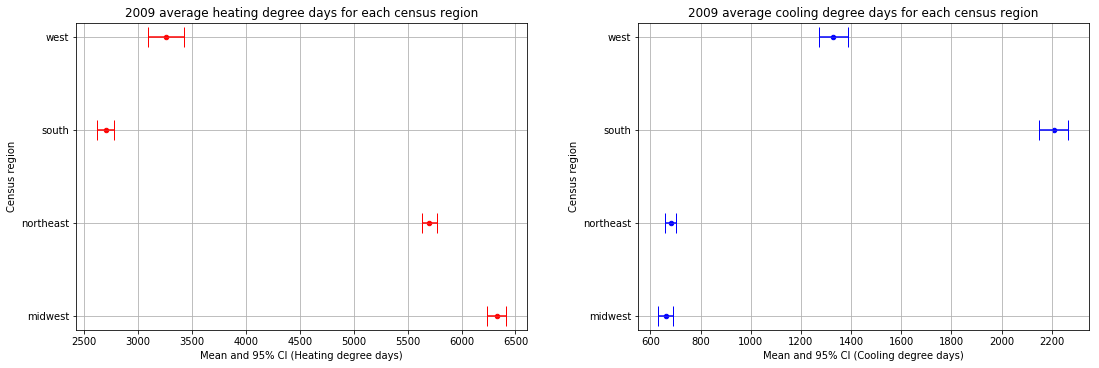

In [33]:
fig1, ax1 = plt.subplots(nrows=1, ncols=2)
_ = fig1.tight_layout()
_ = fig1.set_size_inches(16, 5)
data_09_day_interval.plot.scatter(
    ax = ax1[0],
    x='avg_heat_degree_day',
    y='census_region',
    marker='o',
    color='red'
    )
_ = ax1[0].errorbar(
    x=data_09_day_interval['avg_heat_degree_day'],
    y=data_09_day_interval['census_region'],
    fmt='None',
    xerr=
    ((data_09_day_interval['heat_upr']-data_09_day_interval['heat_lwr'])/2),
    ecolor='red',
    capsize=10
)
data_09_day_interval.plot.scatter(
    ax = ax1[1],
    x='avg_cool_degree_day',
    y='census_region',
    marker='o',
    color='blue'
    )
_ = ax1[1].errorbar(
    x=data_09_day_interval['avg_cool_degree_day'],
    y=data_09_day_interval['census_region'],
    fmt='None',
    xerr=
    ((data_09_day_interval['cool_upr']-data_09_day_interval['cool_lwr'])/2),
    ecolor='blue',
    capsize=10
)
_ = ax1[0].set_xlabel('Mean and 95% CI (Heating degree days)')
_ = ax1[0].set_ylabel('Census region')
_ = ax1[1].set_xlabel('Mean and 95% CI (Cooling degree days)')
_ = ax1[1].set_ylabel('Census region')
_ = ax1[0].set_title('2009 average heating degree days for each census region')
_ = ax1[1].set_title('2009 average cooling degree days for each census region')
_ = ax1[0].grid()
_ = ax1[1].grid()
fig = Gcf.get_all_fig_managers()[-1].canvas.figure
image_data = ("data:image/png;base64,%s" % b64encode(print_figure(fig))
    .decode("utf-8"))
Gcf.destroy_fig(fig)
HTML(
"""
<b><center> Figure 1.</b> 
<em>Average heating and cooling degree days and 0.95 confidence interval for
 each census region in 2009.
<br> <img src='%s'> <br>
"""
% image_data
)


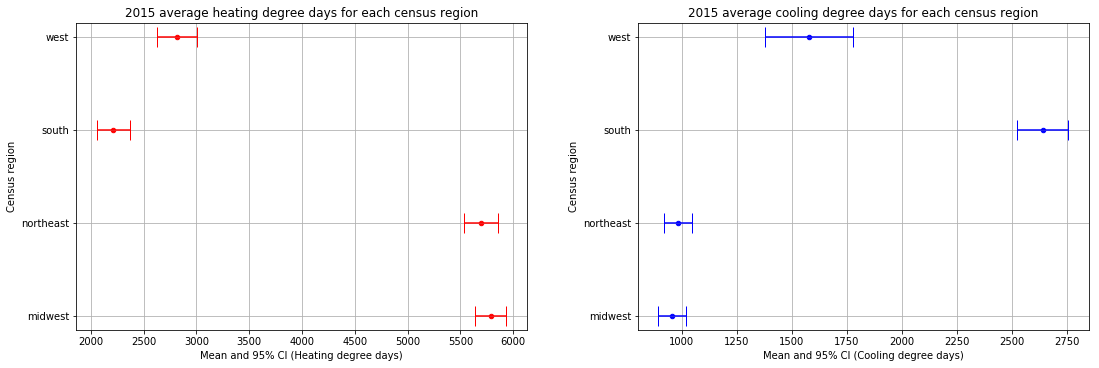

In [34]:
fig2, ax2 = plt.subplots(nrows=1, ncols=2)
_ = fig2.tight_layout()
_ = fig2.set_size_inches(16, 5)
data_15_day_interval.plot.scatter(
    ax = ax2[0],
    x='avg_heat_degree_day',
    y='census_region',
    marker='o',
    color='red'
    )
_ = ax2[0].errorbar(
    x=data_15_day_interval['avg_heat_degree_day'],
    y=data_15_day_interval['census_region'],
    fmt='None',
    xerr=
    ((data_15_day_interval['heat_upr']-data_15_day_interval['heat_lwr'])/2),
    ecolor='red',
    capsize=10
)
data_15_day_interval.plot.scatter(
    ax = ax2[1],
    x='avg_cool_degree_day',
    y='census_region',
    marker='o',
    color='blue'
    )
_ = ax2[1].errorbar(
    x=data_15_day_interval['avg_cool_degree_day'],
    y=data_15_day_interval['census_region'],
    fmt='None',
    xerr=
    ((data_15_day_interval['cool_upr']-data_15_day_interval['cool_lwr'])/2),
    ecolor='blue',
    capsize=10
)
_ = ax2[0].set_xlabel('Mean and 95% CI (Heating degree days)')
_ = ax2[0].set_ylabel('Census region')
_ = ax2[1].set_xlabel('Mean and 95% CI (Cooling degree days)')
_ = ax2[1].set_ylabel('Census region')
_ = ax2[0].set_title('2015 average heating degree days for each census region')
_ = ax2[1].set_title('2015 average cooling degree days for each census region')
_ = ax2[0].grid()
_ = ax2[1].grid()
fig = Gcf.get_all_fig_managers()[-1].canvas.figure
image_data = ("data:image/png;base64,%s" % b64encode(print_figure(fig))
    .decode("utf-8"))
Gcf.destroy_fig(fig)
HTML(
"""
<b><center> Figure 2.</b> 
<em>Average heating and cooling degree days and 0.95 confidence interval for 
each census region in 2015.
<br> <img src='%s'> <br>
"""
% image_data
)

According to the figures above, midwest region have the highest avearge on
heating degree days both in 2009 and 2015, and south region have the lowest
average heating degree days both in 2009 and 2015. As for cooling degree
days, the condition reverse, with south region have the highest cooling
degree days and midwest have the lowest cooling degree days both in 2009 
and 2015. West region in 2015 have a relatively large confiedence interval,
which indicates that the data from that region may varies a lot. And the
difference between northeast and midwest region is small, generally speaking.


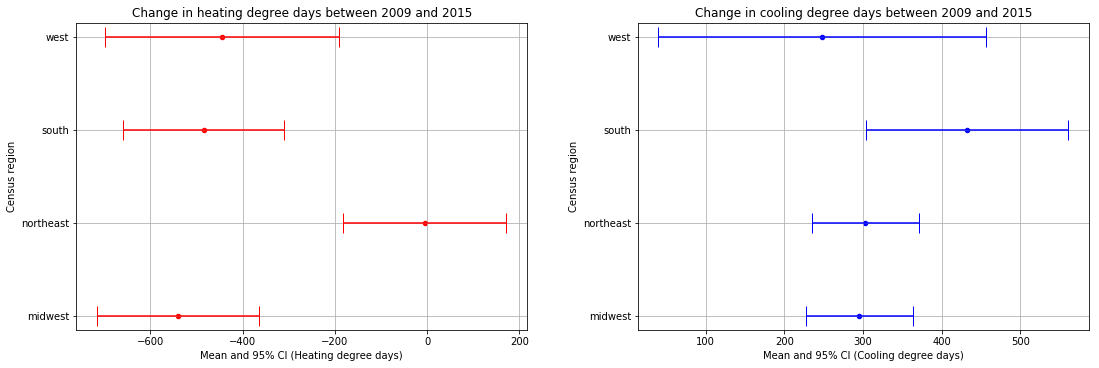

In [35]:
fig3, ax3 = plt.subplots(nrows=1, ncols=2)
_ = fig3.tight_layout()
_ = fig3.set_size_inches(16, 5)
data_day.plot.scatter(
    ax = ax3[0],
    x='avg_heat_diff',
    y='census_region',
    marker='o',
    color='red'
    )
_ = ax3[0].errorbar(
    x=data_day['avg_heat_diff'],
    y=data_day['census_region'],
    fmt='None',
    xerr=((data_day['heat_diff_upr']-data_day['heat_diff_lwr'])/2),
    ecolor='red',
    capsize=10
)
data_day.plot.scatter(
    ax = ax3[1],
    x='avg_cool_diff',
    y='census_region',
    marker='o',
    color='blue'
    )
_ = ax3[1].errorbar(
    x=data_day['avg_cool_diff'],
    y=data_day['census_region'],
    fmt='None',
    xerr=((data_day['cool_diff_upr']-data_day['cool_diff_lwr'])/2),
    ecolor='blue',
    capsize=10
)
_ = ax3[0].set_xlabel('Mean and 95% CI (Heating degree days)')
_ = ax3[0].set_ylabel('Census region')
_ = ax3[1].set_xlabel('Mean and 95% CI (Cooling degree days)')
_ = ax3[1].set_ylabel('Census region')
_ = ax3[0].set_title('Change in heating degree days between 2009 and 2015')
_ = ax3[1].set_title('Change in cooling degree days between 2009 and 2015')
_ = ax3[0].grid()
_ = ax3[1].grid()
fig = Gcf.get_all_fig_managers()[-1].canvas.figure
image_data = ("data:image/png;base64,%s" % b64encode(print_figure(fig))
    .decode("utf-8"))
Gcf.destroy_fig(fig)
HTML(
"""
<b><center> Figure 3.</b> 
<em>Average change of heating and cooling degree days and 0.95 confidence 
interval for each census region between 2009 and 2015.</em>
The result is conducted by the data in 2015 minus the data in 2009.
<br> <img src='%s'> <br>
"""
% image_data
)


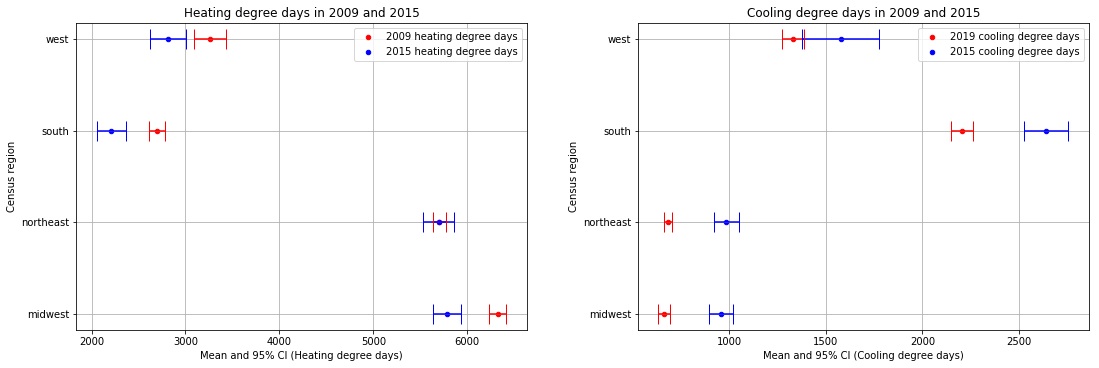

In [36]:
fig4, ax4 = plt.subplots(nrows=1, ncols=2)
_ = fig4.tight_layout()
_ = fig4.set_size_inches(16, 5)
data_09_day_interval.plot.scatter(
    ax = ax4[0],
    x='avg_heat_degree_day',
    y='census_region',
    marker='o',
    color='red'
    )
_ = ax4[0].errorbar(
    x=data_09_day_interval['avg_heat_degree_day'],
    y=data_09_day_interval['census_region'],
    fmt='None',
    xerr=
    ((data_09_day_interval['heat_upr']-data_09_day_interval['heat_lwr'])/2),
    ecolor='red',
    capsize=10
)
data_09_day_interval.plot.scatter(
    ax = ax4[1],
    x='avg_cool_degree_day',
    y='census_region',
    marker='o',
    color='red'
    )
_ = ax4[1].errorbar(
    x=data_09_day_interval['avg_cool_degree_day'],
    y=data_09_day_interval['census_region'],
    fmt='None',
    xerr=
    ((data_09_day_interval['cool_upr']-data_09_day_interval['cool_lwr'])/2),
    ecolor='red',
    capsize=10
)

data_15_day_interval.plot.scatter(
    ax = ax4[0],
    x='avg_heat_degree_day',
    y='census_region',
    marker='o',
    color='blue'
    )
_ = ax4[0].errorbar(
    x=data_15_day_interval['avg_heat_degree_day'],
    y=data_15_day_interval['census_region'],
    fmt='None',
    xerr=
    ((data_15_day_interval['heat_upr']-data_15_day_interval['heat_lwr'])/2),
    ecolor='blue',
    capsize=10
)
data_15_day_interval.plot.scatter(
    ax = ax4[1],
    x='avg_cool_degree_day',
    y='census_region',
    marker='o',
    color='blue'
    )
_ = ax4[1].errorbar(
    x=data_15_day_interval['avg_cool_degree_day'],
    y=data_15_day_interval['census_region'],
    fmt='None',
    xerr=
    ((data_15_day_interval['cool_upr']-data_15_day_interval['cool_lwr'])/2),
    ecolor='blue',
    capsize=10
)
_ = ax4[0].set_xlabel('Mean and 95% CI (Heating degree days)')
_ = ax4[0].set_ylabel('Census region')
_ = ax4[1].set_xlabel('Mean and 95% CI (Cooling degree days)')
_ = ax4[1].set_ylabel('Census region')
_ = ax4[0].legend(['2009 heating degree days','2015 heating degree days'],
                  loc='best')
_ = ax4[1].legend(['2019 cooling degree days','2015 cooling degree days'],
                  loc='upper right')
_ = ax4[0].set_title('Heating degree days in 2009 and 2015')
_ = ax4[1].set_title('Cooling degree days in 2009 and 2015')
_ = ax4[0].grid()
_ = ax4[1].grid()
fig = Gcf.get_all_fig_managers()[-1].canvas.figure
image_data = ("data:image/png;base64,%s" % b64encode(print_figure(fig))
    .decode("utf-8"))
Gcf.destroy_fig(fig)
HTML(
"""
<b><center> Figure 4.</b> 
<em>Average heating and cooling degree days and 0.95 confidence interval for
 each census region in 2009 and 2015.</em>
<br> <img src='%s'> <br>
"""
% image_data
)

According to the above figures, the average heating degree days in 2009 and
2015 of northeast doesn't varies too much compare with the rest three
regions, and there is a downward trend in average heating degree days in all
states and the change in midwest is the most significant. As for average
cooling degree days, the result of all the regions increase and the increment
in south region is most significant. The overall result turns out that
compare with 2009, tempearture in 2015 is higher.